# 1. Import libraries


In [1]:
import random
from IPython.display import clear_output
import matplotlib.pylab as plt
import numpy as np

- *random* is used for agent exploration
- *clear_output* is used for updating the Tic-Tac-Toe board
- *matplotlib.pylab* and *numpy* are used to show the agent's learning

# 2. Define players
Create a parent Player class that prints the current state of the board. We want both Human and AI players to be able to print the current board.

In [2]:
class Player:

    def show_board(self, board):
        # Show the board in the following format:
        #          7 | 8 | 9 
        #          4 | 5 | 6
        #          1 | 2 | 3         
        print('|'.join(board[6:9]))
        print('|'.join(board[3:6]))
        print('|'.join(board[0:3]))

Create a Human Player class. The Human Player will allow to play against a trained AI Player. The fundamental method of a Human player is to provide valid inputs. It does not get trained, thus its reward method is empty.

In [3]:
# Create human player
class HumanPlayer(Player):
    # Inherit Player class

    def reward(self, value, board):
        # The human player does not get trained.
        pass

    def make_move(self, board):
        # The human player has to put a valid input; Try until the input is valid
        while True:
            try:
                # Show updated board
                super().show_board(board)            
                clear_output(wait=True)
                # Provide valid input
                move = input('Your next move (cell index 1-9):')
                move = int(move)
                if not (move - 1 in range(9)) or board[move-1]!=' ' :
                    raise ValueError
            except ValueError:
                print('Invalid move; try again:\n')
            else:
                return move - 1

Create an AI Player class. The AI Player will take actions based on an epsilon-greedy Q-learning policy.

In [4]:
# Create AI player
class AIPlayer(Player):
    # Inherit Player class

    def __init__(self, epsilon=0.4, alpha=0.3, gamma=0.9, default_q=1):
        # epsilon: probability of exploration
        self.EPSILON = epsilon
        # learning rate
        self.ALPHA = alpha
        # discount parameter
        self.GAMMA = gamma
        # default values for Q
        self.DEFAULT_Q = default_q
        # Q(s,a): reward for a state-action pair
        self.q = {}
        # previous move
        self.move = None
        # board in previous iteration
        self.prev_board = (' ',) * 9
        # store training rewards
        self.rewards = []

    def available_moves(self, board):
        # empty cells on the current board
        return [i for i in range(9) if board[i] == ' ']

    def get_q(self, state, action):
        # return Q value, and create a new one if it does not exist for the current state-action pair
        if self.q.get((state, action)) is None:
            self.q[(state, action)] = self.DEFAULT_Q
        return self.q[(state, action)]

    def make_move(self, board):
        # make a random move with epsilon probability or pick the action with the highest Q value
        
        # retrieve available moves
        self.prev_board = tuple(board)
        actions = self.available_moves(board)

        if random.random() < self.EPSILON:
            # exploration
            self.move = random.choice(actions)
        else:
            # exploitation: epsilon-greedy Q-learning
            q_values = [self.get_q(self.prev_board, a) for a in actions]
            max_q_value = max(q_values)
            # if there are multiple best actions, choose one at random
            if q_values.count(max_q_value) > 1:
                best_actions = [i for i in range(len(actions)) if q_values[i] == max_q_value]
                best_move = actions[random.choice(best_actions)]
            else:
                best_move = actions[q_values.index(max_q_value)]
            self.move = best_move
        return self.move

    def reward(self, reward, board):
        # update Q(s,a) and store reward
        prev_q = self.get_q(self.prev_board, self.move)
        max_q_new = max([self.get_q(tuple(board), a) for a in self.available_moves(self.prev_board)])
        self.q[(self.prev_board, self.move)] = prev_q + self.ALPHA * (reward + self.GAMMA * max_q_new - prev_q)
        self.rewards.append(reward)

# 3. Define game
Create the game environment and define the marker symbols and rewards. In this environment, the AI player receives a reward of value 10 for a win, -10 for a loss and 0 for a tie. 

The first player is selected randomnly. Then, each player takes turns and makes a move on the board. In each round, the active player is defined as the "player", and the player that is waiting is the "other_player". In a turn, it is first checked if the last move ended the game. If not, the player makes a move.

The game is over either when a player successfully puts three markers in a row, column or diagonal, or when the board is full.


In [5]:
class TicTacToe:
    # Game environment class
    
    # Markers
    BLANK = ' '
    AI_PLAYER = 'X'
    HUMAN_PLAYER = '0'
    # Rewards
    REWARD_WIN = 10
    REWARD_LOSE = -10
    REWARD_TIE = 0

    def __init__(self, player1, player2):
        # Game initialization
        self.player1 = player1
        self.player2 = player2
        # Check if there is a human playing
        self.isHuman = isinstance(player1, HumanPlayer) or isinstance(player2, HumanPlayer)
        # randomly choose which player starts first and initialize board
        self.first_player_turn = random.choice([True, False])
        self.board = [' '] * 9

    def play(self):
        # Game: Continues until the game is over
        while True:
            if self.first_player_turn:
                # AI player's turn
                player = self.player1
                other_player = self.player2
                player_markers = (self.AI_PLAYER, self.HUMAN_PLAYER)
            else:
                # Human player's turn; markers are not printed during training, 
                # a second AI player will use the human marker during training
                player = self.player2
                other_player = self.player1
                player_markers = (self.HUMAN_PLAYER, self.AI_PLAYER)

            # check game (win, lose, tie)
            # if someone won, that is the "other player" as the current player has not made a move yet
            game_over, winner = self.is_game_over(player_markers[1])
            
            # game over: distribute training rewards and show outcome 
            if game_over:
                if winner:
                    # if someone won, that is the "other player" as the current player has not made a move yet
                    player.reward(self.REWARD_LOSE, self.board[:])
                    other_player.reward(self.REWARD_WIN, self.board[:])
                    if self.isHuman:
                        other_player.show_board(self.board)
                        print('\n %s won!' % other_player.__class__.__name__)
                else:
                    # game is over with a tie
                    player.reward(self.REWARD_TIE, self.board[:])
                    other_player.reward(self.REWARD_TIE, self.board[:])
                    if self.isHuman:
                        other_player.show_board(self.board)
                        print('Tie!')
                break
            # next player's turn   
            self.first_player_turn = not self.first_player_turn
            # player makes a move
            move = player.make_move(self.board)        
            self.board[move] = player_markers[0]

    def is_game_over(self, player_marker):
        # check rows
        for i in range(3):
            if self.board[3 * i + 0] == player_marker and \
                    self.board[3 * i + 1] == player_marker and \
                    self.board[3 * i + 2] == player_marker:
                return True, player_marker
        # check columns
        for j in range(3):
            if self.board[j + 0] == player_marker and \
                    self.board[j + 3] == player_marker and \
                    self.board[j + 6] == player_marker:
                return True, player_marker
        # check diagonals
        if self.board[0] == player_marker and self.board[4] == player_marker and self.board[8] == player_marker:
            return True, player_marker
        if self.board[2] == player_marker and self.board[4] == player_marker and self.board[6] == player_marker:
            return True, player_marker

        # check for a tie
        if self.board.count(' ') == 0:
            return True, None
        else:
            return False, None


# 4. Train AI players
Train an AI player. We need two AI players that will compete each other to simulate several games for training. The second AI player is more adventurous (larger epsilon), deciding more suboptimal actions to create more scenarios. 

In [16]:
TRAINING_EXAMPLES = 10000000
TRAINING_EPSILON_1 = 0.2
TRAINING_EPSILON_2 = 0.3

# train AI player
ai_player_1 = AIPlayer()
ai_player_2 = AIPlayer()
print('Training the AI players...')
ai_player_1.EPSILON = TRAINING_EPSILON_1
ai_player_2.EPSILON = TRAINING_EPSILON_2

# training
for _ in range(TRAINING_EXAMPLES):
    game = TicTacToe(ai_player_1, ai_player_2)
    game.play()

print('Training is Done')

Training the AI players...
Training is Done


Plot training results. The less adventurous AI player played optimally more frequently and ended up accumulating more rewards. In the initial training games, the AI player did not know many optimal moves yet, and the winner was changing more frequently. As the training continues, the more conservative player ends up accumulating more wins.

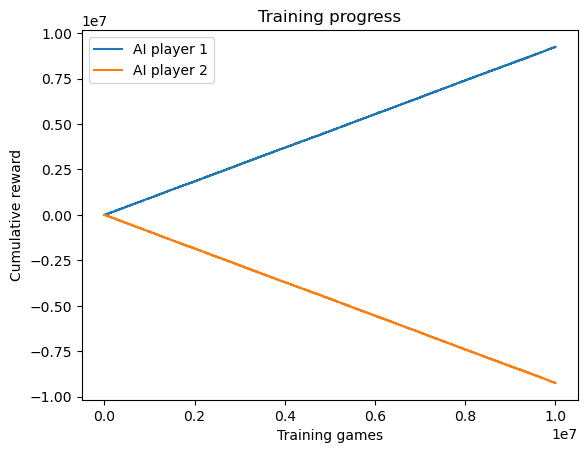

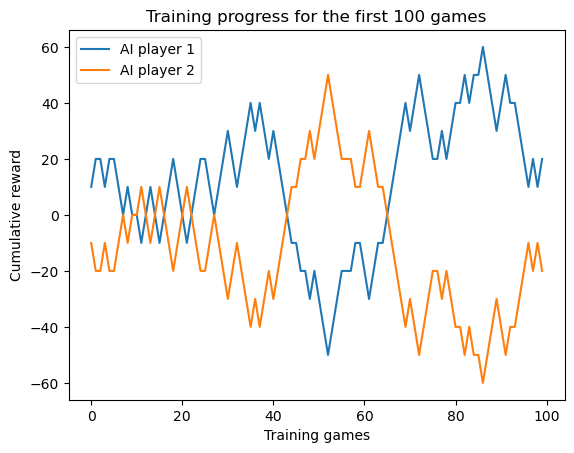

In [17]:
# plot accumulated rewards for the two competing AI players
plt.subplots()
plt.plot(np.cumsum(ai_player_1.rewards))
plt.plot(np.cumsum(ai_player_2.rewards))
plt.xlabel('Training games')
plt.ylabel('Cumulative reward')
plt.title('Training progress')
plt.legend(['AI player 1','AI player 2'])

# plot accumulated rewards for the two competing AI players for the first 100 games
plt.subplots()
plt.plot(np.cumsum(ai_player_1.rewards[0:100]))
plt.plot(np.cumsum(ai_player_2.rewards[0:100]))
plt.xlabel('Training games')
plt.ylabel('Cumulative reward')
plt.title('Training progress for the first 100 games')
plt.legend(['AI player 1','AI player 2'])

plt.show()

# 5. Play
Play Tic-Tac-Toe against the trained AI player!

In [34]:
# After training, set exploration to 0, so that the AI player will play optimally based on the training
ai_player_1.EPSILON = 0
human_player = HumanPlayer()
game = TicTacToe(ai_player_1, human_player)
game.play()


Your next move (cell index 1-9):6
0|X|X
X|0|0
X|0|X
Tie!
